# Learning goals
After today's lesson you should be able to:
- Implement geodemographic and regionalization clustering

This week's lesson is a simplied version of:  
- The [Week 8 on Linear Regression from General Assembly's Data Science Course](https://github.com/justmarkham/DAT4)


In [170]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# this allows plots to appear directly in the notebook
%matplotlib inline

## Example: Advertising Data

Let's take a look at some data, ask some questions about that data, and then use linear regression to answer those questions!

In [171]:
# read data into a DataFrame
data = pd.read_csv('https://raw.githubusercontent.com/justmarkham/scikit-learn-videos/master/data/Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


What are the **features**?
- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio
- Newspaper: advertising dollars spent on Newspaper

What is the **response**?
- Sales: sales of a single product in a given market (in thousands of widgets)

In [172]:
# print the shape of the DataFrame
data.shape

(200, 4)

There are 200 **observations**, and thus 200 markets in the dataset.

<Axes: xlabel='Newspaper', ylabel='Sales'>

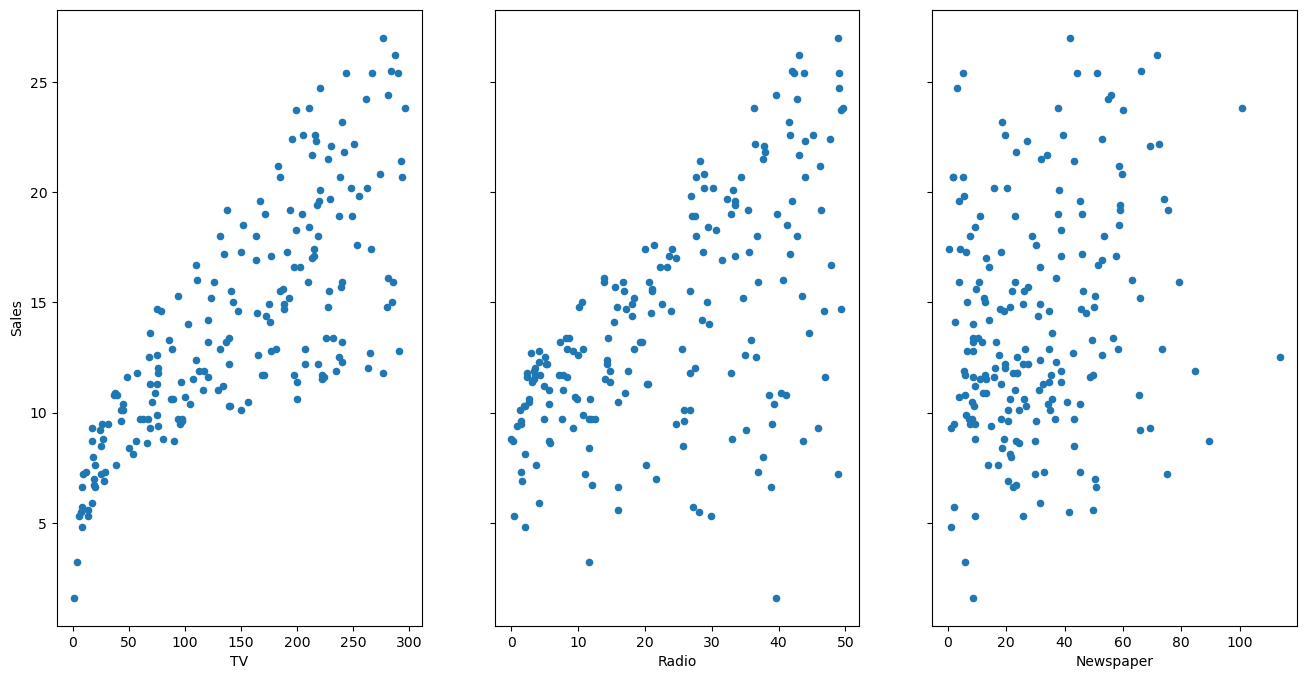

In [173]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])

## Questions About the Advertising Data

Let's pretend you work for the company that manufactures and markets this widget. The company might ask you the following: On the basis of this data, how should we spend our advertising money in the future?

This general question might lead you to more specific questions:
1. Is there a relationship between ads and sales?
2. How strong is that relationship?
3. Which ad types contribute to sales?
4. What is the effect of each ad type of sales?
5. Given ad spending in a particular market, can sales be predicted?

We will explore these questions below!

## Simple Linear Regression

Simple linear regression is an approach for predicting a **quantitative response** using a **single feature** (or "predictor" or "input variable"). It takes the following form:

$y = \beta_0 + \beta_1x$

What does each term represent?
- $y$ is the response
- $x$ is the feature
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for x

Together, $\beta_0$ and $\beta_1$ are called the **model coefficients**. To create your model, you must "learn" the values of these coefficients. And once we've learned these coefficients, we can use the model to predict Sales!

## Estimating ("Learning") Model Coefficients

Generally speaking, coefficients are estimated using the **least squares criterion**, which means we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors"):

</figure>
<img src="https://www.dropbox.com/s/65mihrlxzdve48g/08_estimating_coefficients.png?dl=1" alt="drawing" width="500" style="display: block; margin: 0 auto"/>
</figure>


What elements are present in the diagram?
- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the distances between the observed values and the least squares line.

How do the model coefficients relate to the least squares line?
- $\beta_0$ is the **intercept** (the value of $y$ when $x$=0)
- $\beta_1$ is the **slope** (the change in $y$ divided by change in $x$)

Here is a graphical depiction of those calculations:

</figure>
<img src="https://www.dropbox.com/s/bg7z9k3mne5zop9/08_slope_intercept.png?dl=1" alt="drawing" width="500" style="display: block; margin: 0 auto"/>
</figure>


Let's use **Statsmodels** to estimate the model coefficients for the advertising data:

In [174]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='Sales ~ TV', data=data).fit()

# print the coefficients
lm.params

Intercept    7.032594
TV           0.047537
dtype: float64

## Interpreting Model Coefficients

How do we interpret the TV coefficient ($\beta_1$)?
- A "unit" increase in TV ad spending is **associated with** a 0.047537 "unit" increase in Sales.
- Or more clearly: An additional $1,000 spent on TV ads is **associated with** an increase in sales of 47.537 widgets.

Note that if an increase in TV ad spending was associated with a **decrease** in sales, $\beta_1$ would be **negative**.

## Using the Model for Prediction

Let's say that there was a new market where the TV advertising spend was **$50,000**. What would we predict for the Sales in that market?

$$y = \beta_0 + \beta_1x$$
$$y = 7.032594 + 0.047537 \times 50$$

In [175]:
# manually calculate the prediction
7.032594 + 0.047537*50

9.409444

Thus, we would predict Sales of **9,409 widgets** in that market.

Of course, we can also use Statsmodels to make the prediction:

In [176]:
# you have to create a DataFrame since the Statsmodels formula interface expects it
X_new = pd.DataFrame({'TV': [50]})
X_new.head()

,TV
0,50


In [177]:
# use the model to make predictions on a new value
lm.predict(X_new)

0    9.409426
dtype: float64

## Plotting the Least Squares Line

Let's make predictions for the **smallest and largest observed values of x**, and then use the predicted values to plot the least squares line:

In [178]:
# create a DataFrame with the minimum and maximum values of TV
X_new = pd.DataFrame({'TV': [data.TV.min(), data.TV.max()]})
X_new.head()

,TV
0,0.7
1,296.4


In [179]:
# make predictions for those x values and store them
preds = lm.predict(X_new)
preds

0     7.065869
1    21.122454
dtype: float64

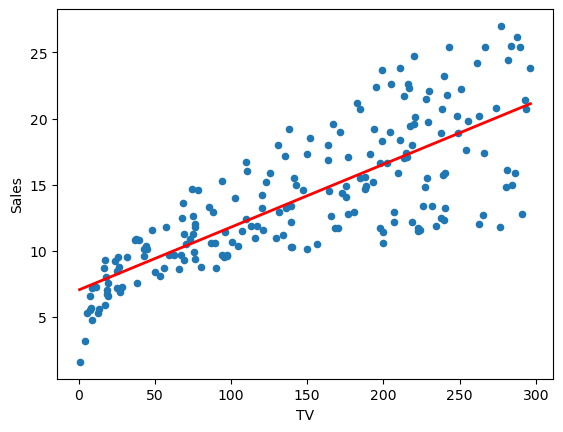

In [180]:
# first, plot the observed data
data.plot(kind='scatter', x='TV', y='Sales')

# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)

## Hypothesis Testing and p-values
Generally speaking, you start with a **null hypothesis** and an **alternative hypothesis** (that is opposite the null). Then, you check whether the data supports **rejecting the null hypothesis** or **failing to reject the null hypothesis**.

(Note that "failing to reject" the null is not the same as "accepting" the null hypothesis. The alternative hypothesis may indeed be true, except that you just don't have enough data to show that.)

As it relates to model coefficients, here is the conventional hypothesis test:
- **null hypothesis:** There is no relationship between TV ads and Sales (and thus $\beta_1$ equals zero)
- **alternative hypothesis:** There is a relationship between TV ads and Sales (and thus $\beta_1$ is not equal to zero)

How do we test this hypothesis? Intuitively, we reject the null (and thus believe the alternative) if the 95% confidence interval **does not include zero**. Conversely, the **p-value** represents the probability that the coefficient is actually zero:

In [181]:
# print the p-values for the model coefficients
lm.pvalues

Intercept    1.406300e-35
TV           1.467390e-42
dtype: float64

If the 95% confidence interval **includes zero**, the p-value for that coefficient will be **greater than 0.05**. If the 95% confidence interval **does not include zero**, the p-value will be **less than 0.05**. Thus, a p-value less than 0.05 is one way to decide whether there is likely a relationship between the feature and the response. (Again, using 0.05 as the cutoff is just a convention.)

In this case, the p-value for TV is far less than 0.05, and so we **believe** that there is a relationship between TV ads and Sales.

Note that we generally ignore the p-value for the intercept.

## How Well Does the Model Fit the data?

The most common way to evaluate the overall fit of a linear model is by the **R-squared** value. R-squared is the **proportion of variance explained**, meaning the proportion of variance in the observed data that is explained by the model, or the reduction in error over the **null model**. (The null model just predicts the mean of the observed response, and thus it has an intercept and no slope.)

R-squared is between 0 and 1, and higher is better because it means that more variance is explained by the model. Here's an example of what R-squared "looks like":


</figure>
<img src="https://www.dropbox.com/s/p937tyo5w16ssuu/08_r_squared.png?dl=1" alt="drawing" width="500" style="display: block; margin: 0 auto"/>
</figure>

You can see that the **blue line** explains some of the variance in the data (R-squared=0.54), the **green line** explains more of the variance (R-squared=0.64), and the **red line** fits the training data even further (R-squared=0.66). (Does the red line look like it's overfitting?)

Let's calculate the R-squared value for our simple linear model:

In [182]:
# print the R-squared value for the model
lm.rsquared

0.611875050850071

Is that a "good" R-squared value? It's hard to say. The threshold for a good R-squared value depends widely on the domain. Therefore, it's most useful as a tool for **comparing different models**.

## Multiple Linear Regression

Simple linear regression can easily be extended to include multiple features. This is called **multiple linear regression**:

$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$

Each $x$ represents a different feature, and each feature has its own coefficient. In this case:

$y = \beta_0 + \beta_1 \times TV + \beta_2 \times Radio + \beta_3 \times Newspaper$

Let's use Statsmodels to estimate these coefficients:

In [183]:
# create a fitted model with all three features
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()

# print the coefficients
lm.params

Intercept    2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64

How do we interpret these coefficients? For a given amount of Radio and Newspaper ad spending, an **increase of $1000 in TV ad spending** is associated with an **increase in Sales of 45.765 widgets**.

A lot of the information we have been reviewing piece-by-piece is available in the model summary output:

In [184]:
# print a summary of the fitted model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           1.58e-96
Time:                        12:06:56   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What are a few key things we learn from this output?

- TV and Radio have significant **p-values**, whereas Newspaper does not. Thus we reject the null hypothesis for TV and Radio (that there is no association between those features and Sales), and fail to reject the null hypothesis for Newspaper.
- TV and Radio ad spending are both **positively associated** with Sales, whereas Newspaper ad spending is **slightly negatively associated** with Sales. (However, this is irrelevant since we have failed to reject the null hypothesis for Newspaper.)
- This model has a higher **R-squared** (0.897) than the previous model, which means that this model provides a better fit to the data than a model that only includes TV.

## Feature Selection

How do I decide **which features to include** in a linear model? Here's one idea:
- Try different models, and only keep predictors in the model if they have small p-values.
- Check the collinearity between predictors
- Check whether the R-squared value goes up when you add new predictors.

What are the **drawbacks** to this approach?
- Linear models rely upon a lot of **assumptions** (such as the features being independent), and if those assumptions are violated (which they usually are), R-squared and p-values are less reliable.
- Using a p-value cutoff of 0.05 means that if you add 100 predictors to a model that are **pure noise**, 5 of them (on average) will still be counted as significant.
- R-squared is susceptible to **overfitting**, and thus there is no guarantee that a model with a high R-squared value will generalize. Below is an example:

First, let's check the collinearity between TV, radio, and newspaper. What would it mean for deciding on a strategy, if for instance, the correlation between TV and Radio were 1? A good rule of thumb is if the Variance Inflation Factor (VIF) $\frac{1}{1-R^2}$ is 5 or above. 

In [185]:
data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


Since the correlation is pretty low here, we should not be too worried. As a rule of thumb, anything about 0.6 or above, I will do Variance Inflation Factor tests, where we find
$$
VIF = \frac{1}{1-R_i^2}
$$
where $i$ is the independent variable in question and we regress it on all the other independent variables

In [186]:
lm_vif=smf.ols(formula='Radio ~ Newspaper + Sales', data=data).fit()
print("VIF for Radio is ", 1/(1-lm_vif.rsquared))

VIF for Radio is  1.6241296734772357


In [187]:
# only include TV and Radio in the model
lm = smf.ols(formula='Sales ~ TV + Radio', data=data).fit()
lm.rsquared

0.8971942610828956

In [188]:
lm.rsquared_adj

0.8961505479974428

In [189]:
# add Newspaper to the model (which we believe has no association with Sales)
lm = smf.ols(formula='Sales ~ TV + Radio + Newspaper', data=data).fit()
lm.rsquared

0.8972106381789522

**R-squared will always increase as you add more features to the model**, even if they are unrelated to the response. Thus, selecting the model with the highest R-squared is not a reliable approach for choosing the best linear model.

There is alternative to R-squared called **adjusted R-squared** that penalizes model complexity (to control for overfitting), but it generally [under-penalizes complexity](http://scott.fortmann-roe.com/docs/MeasuringError.html).


In [190]:
lm.rsquared_adj

0.8956373316204668

## Linear Regression in scikit-learn

Let's redo some of the Statsmodels code above in scikit-learn:

In [191]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
# y = data.Sales
y = data['Sales']

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
print(lm.coef_)

2.9388893694594067
[ 0.04576465  0.18853002 -0.00103749]


In [192]:
# pair the feature names with the coefficients
# zip(feature_cols, lm.coef_)

In [193]:
# predict for a new observation
lm.predict(np.array([100, 25, 25]).reshape(1, -1))

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([12.20266701])

In [194]:
# calculate the R-squared
lm.score(X, y)

0.8972106381789522

Note that **p-values** and **confidence intervals** are not (easily) accessible through scikit-learn.

## Handling Categorical Predictors with Two Categories

Up to now, all of our predictors have been numeric. What if one of our predictors was categorical?

Let's create a new feature called **Size**, and randomly assign observations to be **small or large**:

In [195]:
import numpy as np

# set a seed for reproducibility
np.random.seed(12345)

# create a Series of booleans in which roughly half are True
nums = np.random.rand(len(data))
mask_large = nums > 0.5

# initially set Size to small, then change roughly half to be large
data['Size'] = 'small'
data.loc[mask_large, 'Size'] = 'large'
data.head()

,TV,Radio,Newspaper,Sales,Size
1,230.1,37.8,69.2,22.1,large
2,44.5,39.3,45.1,10.4,small
3,17.2,45.9,69.3,9.3,small
4,151.5,41.3,58.5,18.5,small
5,180.8,10.8,58.4,12.9,large


For scikit-learn, we need to represent all data **numerically**. If the feature only has two categories, we can simply create a **dummy variable** that represents the categories as a binary value:

In [196]:
# create a new Series called IsLarge
data['IsLarge'] = data.Size.map({'small':0, 'large':1})
data.head()

,TV,Radio,Newspaper,Sales,Size,IsLarge
1,230.1,37.8,69.2,22.1,large,1
2,44.5,39.3,45.1,10.4,small,0
3,17.2,45.9,69.3,9.3,small,0
4,151.5,41.3,58.5,18.5,small,0
5,180.8,10.8,58.4,12.9,large,1


Let's redo the multiple linear regression and include the **IsLarge** predictor:

In [197]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper', 'IsLarge']
X = data[feature_cols]
y = data.Sales

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print(list(zip(feature_cols, lm.coef_)))

[('TV', 0.04571982092436279), ('Radio', 0.18872814313427866), ('Newspaper', -0.0010976794483516898), ('IsLarge', 0.05742385085482779)]


How do we interpret the **IsLarge coefficient**? For a given amount of TV/Radio/Newspaper ad spending, being a large market is associated with an average **increase** in Sales of 57.42 widgets (as compared to a Small market, which is called the **baseline level**).

What if we had reversed the 0/1 coding and created the feature 'IsSmall' instead? The coefficient would be the same, except it would be **negative instead of positive**. As such, your choice of category for the baseline does not matter, all that changes is your **interpretation** of the coefficient.

## Handling Categorical Predictors with More than Two Categories

Let's create a new feature called **Area**, and randomly assign observations to be **rural, suburban, or urban**:

In [198]:
# set a seed for reproducibility
np.random.seed(123456)

# assign roughly one third of observations to each group
nums = np.random.rand(len(data))
mask_suburban = (nums > 0.33) & (nums < 0.66)
mask_urban = nums > 0.66
data['Area'] = 'rural'
data.loc[mask_suburban, 'Area'] = 'suburban'
data.loc[mask_urban, 'Area'] = 'urban'
data.head()

,TV,Radio,Newspaper,Sales,Size,IsLarge,Area
1,230.1,37.8,69.2,22.1,large,1,rural
2,44.5,39.3,45.1,10.4,small,0,urban
3,17.2,45.9,69.3,9.3,small,0,rural
4,151.5,41.3,58.5,18.5,small,0,urban
5,180.8,10.8,58.4,12.9,large,1,suburban


We have to represent Area numerically, but we can't simply code it as 0=rural, 1=suburban, 2=urban because that would imply an **ordered relationship** between suburban and urban (and thus urban is somehow "twice" the suburban category).

Instead, we create **another dummy variable**:

In [199]:
# create three dummy variables using get_dummies, then exclude the first dummy column
area_dummies = pd.get_dummies(data.Area, prefix='Area').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
data = pd.concat([data, area_dummies], axis=1)
data.head()

,TV,Radio,Newspaper,Sales,Size,IsLarge,Area,Area_suburban,Area_urban
1,230.1,37.8,69.2,22.1,large,1,rural,False,False
2,44.5,39.3,45.1,10.4,small,0,urban,False,True
3,17.2,45.9,69.3,9.3,small,0,rural,False,False
4,151.5,41.3,58.5,18.5,small,0,urban,False,True
5,180.8,10.8,58.4,12.9,large,1,suburban,True,False


Here is how we interpret the coding:
- **rural** is coded as Area_suburban=0 and Area_urban=0
- **suburban** is coded as Area_suburban=1 and Area_urban=0
- **urban** is coded as Area_suburban=0 and Area_urban=1

Why do we only need **two dummy variables, not three?** Because two dummies captures all of the information about the Area feature, and implicitly defines rural as the baseline level. (In general, if you have a categorical feature with k levels, you create k-1 dummy variables.)

If this is confusing, think about why we only needed one dummy variable for Size (IsLarge), not two dummy variables (IsSmall and IsLarge).

Let's include the two new dummy variables in the model:

In [200]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper', 'IsLarge', 'Area_suburban', 'Area_urban']
X = data[feature_cols]
y = data.Sales

# instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print coefficients
print(list(zip(feature_cols, lm.coef_)))

[('TV', 0.04574401036331375), ('Radio', 0.18786669552525814), ('Newspaper', -0.0010876977267108045), ('IsLarge', 0.07739660749747926), ('Area_suburban', -0.10656299015958633), ('Area_urban', 0.26813802165220074)]


How do we interpret the coefficients?
- Holding all other variables fixed, being a **suburban** area is associated with an average **decrease** in Sales of 106.56 widgets (as compared to the baseline level, which is rural).
- Being an **urban** area is associated with an average **increase** in Sales of 268.13 widgets (as compared to rural).

**A final note about dummy encoding:** If you have categories that can be ranked (i.e., strongly disagree, disagree, neutral, agree, strongly agree), you can potentially use a single dummy variable and represent the categories numerically (such as 1, 2, 3, 4, 5).

## What Didn't We Cover?

- Detecting collinearity
- Diagnosing model fit
- Transforming predictors to fit non-linear relationships
- Interaction terms
- Assumptions of linear regression
- And so much more!

You could certainly go very deep into linear regression, and learn how to apply it really, really well. It's an excellent way to **start your modeling process** when working a regression problem. However, it is limited by the fact that it can only make good predictions if there is a **linear relationship** between the features and the response, which is why more complex methods (with higher variance and lower bias) will often outperform linear regression.

Therefore, we want you to understand linear regression conceptually, understand its strengths and weaknesses, be familiar with the terminology, and know how to apply it. However, we also want to spend time on many other machine learning models, which is why we aren't going deeper here.

## Q.1


The chief of automobile maintenance for the city of Normal feels that maintenance costs on high-mileage cars are much higher than those costs for low-mileage cars. The maintenance chief regresses yearly maintenance costs for a sample of 200 cars on each car's total mileage for the year. She finds the following: 
$$
\hat{Y} = \$50 + 0.030X
$$
where $Y$ is the maintenance cost (in dollars) for the year and $X$ is the mileage on the car. 

**(a)** Is there a relationship between maintenance costs and mileage?

**(b)** What are the predicted maintenance costs of a car with 50,000 miles?

**(c)** The maintenance chief considers 1,000 dollars in maintenance a year excessive. For this criterion, how many miles will generate maintenance costs of 1,000 dollars? 



ANSWERS:

**(a)** Yes, there seems to be a positive correlation between mileage and maintenance costs (assuming that we were able to reject the null hypothesis).

**(b)** Y = 50 + 0.030*50000 = 1550

**(c)** 31667 miles will generate maintenance costs of 1,000 dollars. 

## Q.2
The Wisconsin Association of School Districts is interested in the relationship between school district population and funding for schools. From a sample of 300 school districts, the association uses simple regression to predict total school district expenditures in dollars ($Y$) using the school district's population ($X$ = number of persons residing in the district). It finds 
$$
\hat{Y} = 4,566 + 824X
$$
Where the $R^2$ = 0.78, p-value for the intercept is 0.23 and the p-value for the slope is 0.01. 

Express in plain English the interpretations of the following in this scenario: 

**(a)** the intercept: the amount of money the school spends with no school district population (probably base maintenance costs)

**(b)** the slope: the additional amount of money the school spends for increase in one person in the school district

**(c)** the p-value for the intercept: the probability that the intercept is zero, which is more than 0.05, we cannot reject the null hypothesis. This means that we have some doubts about the value of the intercept.

**(d)** the p-value for the slope: probability that the slope is actually zero, which is less than 0.05, and we can accept the slope with confidence.

## Q.3
Dick Engstrom and Mike MacDonald are interested in the relationship between African-American representation on city councils and the structure of the electoral system. Their independent variable is the percentage of African Americans in the population; their dependent variable is the percentage of seats on the city council that are held by African Americans. Engstrom and MacDonald want to compare representation under single-member district election systems and under at-large election systems. They get the following results: 

**At-large systems**
$$
\hat{Y} = 0.348 + 0.495X
$$ with $R^2$ = 0.34

**Single-Member District System**
$$
\hat{Y} = -0.832 + 0.994X
$$ with $R^2$ = 0.816

For each equation, interpret the slope, intercept, and $R^2$. Get the predicted city council representation of a city with 25% African-American population under both systems. What can you say about the relative representation of African Americans under each type of system? (3 pts)

In [201]:
y_atlarge = 0.348 + 0.495*25
y_singlemember = -0.832 + 0.994*25
print(f"at large systems: {y_atlarge}%, single-member district system: {y_singlemember}%")

at large systems: 12.723%, single-member district system: 24.018%


In the at large systems, the percentage of seats on the city council held by African-Americans increases less than the percentage of seats in Single-Member District System per percentage of African Americans in the population.

## Q.4

We would like to predict the mileage per gallon (`mpg`) for a sample of cars and evaluate our model. We will be using the `mtcars.csv` dataset (see below). 

In [202]:
import pandas as pd
dfcars = pd.read_csv('https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv')

Now, we need to choose ONE variable that we think will be good predictors for the dependent variable `mpg`.

**(a)**: Pick ONE variable to use as a predictor for simple linear regression. Create a markdown cell below and discuss your reasons. You may want to justify this with some visualizations. Is there a second variable you'd like to use as well, say for multiple linear regression with two predictors?

In [203]:
dfcars.columns

Index(['model', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am',
       'gear', 'carb'],
      dtype='object')

In [204]:
# import seaborn as sns
# _ = sns.pairplot(
#     dfcars, kind="reg", diag_kind="kde"
# )

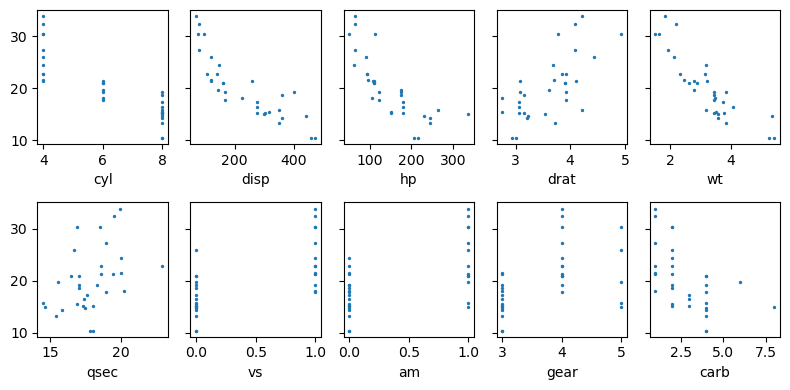

In [205]:
cols = dfcars.columns

fig, axs = plt.subplots(2, 5, sharey=True, figsize=(8, 4))
for i in range(0, 10):
    row = i // 5  # Calculate the row index
    col = i % 5   # Calculate the column index
    axs[row, col].scatter(x=dfcars[cols[i+2]], y=dfcars['mpg'], s=2)
    axs[row, col].set_xlabel(cols[i+2])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Based on the plots, there seems to be a clear relationship between disp (displacement) and mpg. So I chose disp as the independent variable to predict mpg.

**(b)**: Fit your dependent and independent variables using simple linear regression. Print out the regression summary and explain what the intercept, coefficients, $R^2$, and p-values for each outcome tells us. Plot the data and the prediction. 

In [206]:
## INSERT YOUR CODE HERE

# Fit your model here

# create a fitted model with all three features
lm = smf.ols(formula='mpg ~ disp', data=dfcars).fit()

# print the coefficients
lm.params

Intercept    29.599855
disp         -0.041215
dtype: float64

In [207]:
# Print the results summary from your model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     76.51
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           9.38e-10
Time:                        12:06:58   Log-Likelihood:                -82.105
No. Observations:                  32   AIC:                             168.2
Df Residuals:                      30   BIC:                             171.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.5999      1.230     24.070      0.000      27.088      32.111
disp          -0.0412      0.005     -8.747      0.000      -0.051      -0.032
==============================================================================
Omnibus:                        3.368   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.186   Jarque-Bera (JB):                3.049
Skew:                           0.719   Prob(JB):                        0.218
Kurtosis:                       2.532   Cond. No.                         558.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The P value is less than 0.05 for both the intercept and slope, and there is a high R^2, so this linear regression represents a close fit to the data.

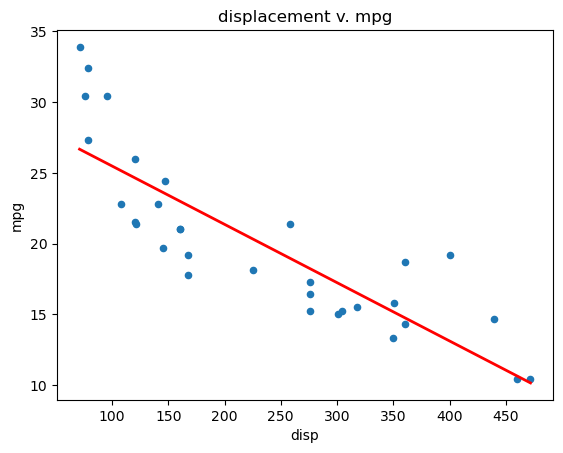

In [208]:
## INSERT YOUR CODE HERE

X_new = pd.DataFrame({'disp': [dfcars.disp.min(), dfcars.disp.max()]})
preds = lm.predict(X_new)

#datapoints
dfcars.plot(kind='scatter', x='disp', y='mpg')

# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)
plt.title("displacement v. mpg")
plt.show()

## Q.5

Fit the data using multiple linear regression with TWO predictors. Create two models with two predictors each. Use these models to make `mpg` predictions. Print out the regression summary and explain what the intercept, coefficients, $R^2$, and p-values for each outcome tells us. Plot the data and the predictions.

In [209]:
## INSERT YOUR CODE HERE

# Fit your TWO models here
lm = smf.ols(formula='mpg ~ disp + wt', data=dfcars).fit()

# print the coefficients
lm.params

Intercept    34.960554
disp         -0.017725
wt           -3.350825
dtype: float64

In [210]:
## INSERT YOUR CODE HERE

# Print the results summary from your TWO models here
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     51.69
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           2.74e-10
Time:                        12:06:58   Log-Likelihood:                -78.084
No. Observations:                  32   AIC:                             162.2
Df Residuals:                      29   BIC:                             166.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.9606      2.165     16.151      0.000      30.534      39.388
disp          -0.0177      0.009     -1.929      0.064      -0.037       0.001
wt            -3.3508      1.164     -2.878      0.007      -5.732      -0.970
==============================================================================
Omnibus:                        4.079   Durbin-Watson:                   1.277
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.665
Skew:                           0.812   Prob(JB):                        0.160
Kurtosis:                       2.666   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The P value is not less than 0.05 for both the intercept and slope, but there is a high R^2. This linear regression closely fits the data, but it's unclear if we can accept it as a good measurement because of the p-value.

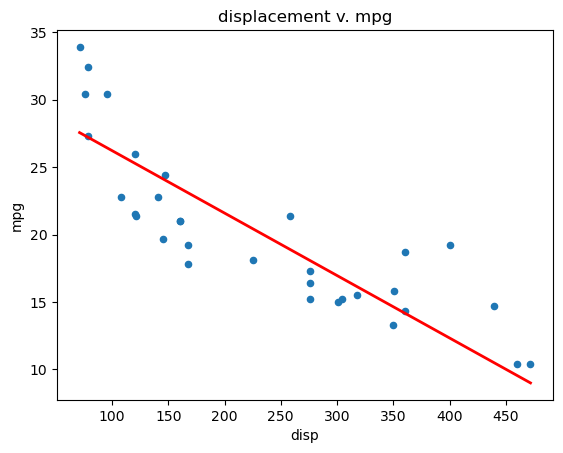

In [211]:
## INSERT YOUR CODE HERE

# Plot your data and the predictions from your TWO models here (separately)

dispmin = dfcars.disp.min()
dispmax = dfcars.disp.max()

wt_dispmin= dfcars[dfcars['disp']==dispmin].wt.values[0]
wt_dispmax= dfcars[dfcars['disp']==dispmax].wt.values[0]

X_new = pd.DataFrame({'disp': [dispmin, dispmax], 'wt': [wt_dispmin, wt_dispmax]})
preds = lm.predict(X_new)

#datapoints
dfcars.plot(kind='scatter', x='disp', y='mpg')
# then, plot the least squares line
plt.plot([dispmin, dispmax], preds, c='red', linewidth=2)

plt.title("displacement v. mpg")
plt.show()

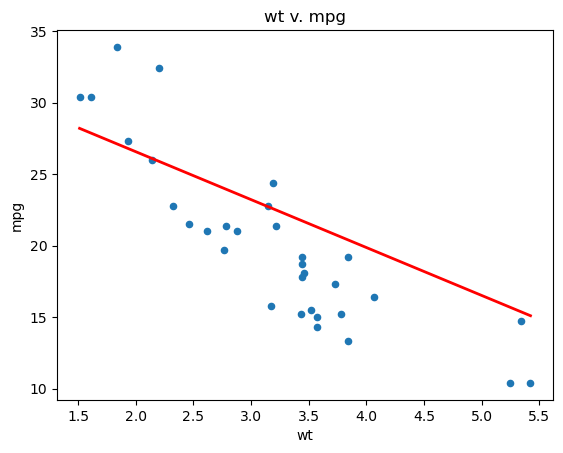

In [212]:
wtmin = dfcars.wt.min()
wtmax = dfcars.wt.max()

disp_wtmin= dfcars[dfcars['wt']==wtmin].disp.values[0]
disp_wtmax= dfcars[dfcars['wt']==wtmin].disp.values[0]

X_new = pd.DataFrame({'wt': [wtmin, wtmax], 'disp': [disp_wtmin, disp_wtmax]})
preds = lm.predict(X_new)

#datapoints
dfcars.plot(kind='scatter', x='wt', y='mpg')
# then, plot the least squares line
plt.plot([wtmin, wtmax], preds, c='red', linewidth=2)

plt.title("wt v. mpg")
plt.show()

How do the results from the two models differ? What can you say about which model is better in terms of prediction? (1 pt)

From the R^2 value alone, the second model is performing better (less error). However, it is unclear if it is a better model, because the p value is lower. I suspect it might be a bit overfit, because wt and disp are not necessarily independent (cars with higher weights also have larger engine sizes and thus larger displacement volumes).